# Fetching Data

In [1]:
import os
from pathlib import Path

# Create directories
for d in ['data/raw', 'data/processed', 'data/images/train', 'data/images/test', 'models']:
    Path(d).mkdir(parents=True, exist_ok=True)

# Copy data (after uploading to Kaggle)
!cp /kaggle/input/*/*.xlsx data/raw/

# Set your API key
os.environ['GOOGLE_MAPS_API_KEY'] = 'YOUR_GOOGLE_MAPS_API_KEY'
os.environ['GOOGLE_MAPS_SIGNING_SECRET'] = 'YOUR_SIGNING_SECRET'

In [2]:
"""
Satellite Image Fetcher for Property Valuation
Downloads satellite images using Google Maps Static API with URL Signing
"""

import os
import time
import requests
import pandas as pd
import base64
import hashlib
import hmac
import urllib.parse
from pathlib import Path
from PIL import Image
from io import BytesIO
from tqdm import tqdm


def sign_url(url: str, secret: str) -> str:
    """
    Args:
        url: The full URL to sign (without signature)
        secret: URL signing secret from Google Cloud Console

    Returns:
        Signed URL with signature parameter
    """
    # Decode secret from URL-safe base64
    decoded_key = base64.urlsafe_b64decode(secret)

    # Parse URL
    url_parts = urllib.parse.urlparse(url)
    url_to_sign = url_parts.path + "?" + url_parts.query

    # Create HMAC-SHA1 signature
    signature = hmac.new(
        decoded_key,
        url_to_sign.encode("utf-8"),
        hashlib.sha1
    )

    # Encode signature
    encoded_signature = base64.urlsafe_b64encode(signature.digest()).decode()

    return f"{url}&signature={encoded_signature}"


class SatelliteImageFetcher:
    """Fetches satellite images from Google Maps Static API with URL signing"""

    def __init__(self, api_key: str, signing_secret: str = None,
                 zoom: int = 18, size: int = 400):
        """
        Initialize the fetcher.

        Args:
            api_key: Google Maps API key
            signing_secret: URL signing secret (optional, but recommended to bypass limits)
            zoom: Zoom level (18 = building level)
            size: Image size in pixels
        """
        self.api_key = api_key
        self.signing_secret = signing_secret
        self.zoom = zoom
        self.size = size
        self.base_url = "https://maps.googleapis.com/maps/api/staticmap"
        self.delay = 0.05  # Rate limiting

        if signing_secret:
            print("URL signing enabled")
        else:
            print("URL signing disabled")

    def fetch_image(self, lat: float, lon: float) -> Image.Image:
        """Function to fetch a image."""
        # Build base URL
        url = (
            f"{self.base_url}"
            f"?center={lat},{lon}"
            f"&zoom={self.zoom}"
            f"&size={self.size}x{self.size}"
            f"&maptype=satellite"
            f"&format=png"
            f"&key={self.api_key}"
        )

        if self.signing_secret:
            url = sign_url(url, self.signing_secret)

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()

            # Check if we got an actual image (not an error page)
            content_type = response.headers.get('content-type', '')
            if 'image' not in content_type:
                print(
                    f"Warning: Got {content_type} instead of image for ({lat}, {lon})")
                return None

            return Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Error fetching ({lat}, {lon}): {e}")
            return None
    
    # How many images already downloaded?
    def count_existing_images(self, df: pd.DataFrame, output_dir: Path) -> int:
        count = 0
        for _, row in df.iterrows():
            if (output_dir / f"{row['id']}.png").exists():
                count += 1
        return count

    def download_batch(self, df: pd.DataFrame, output_dir: str,
                       skip_existing: bool = True) -> dict:
        """
        Download images for all properties in dataframe.

        Args:
            df: DataFrame with 'id', 'lat', 'long' columns
            output_dir: Directory to save images
            skip_existing: Skip already downloaded images

        Returns:
            Stats dictionary with success/failed/skipped counts
        """
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        # Count existing images first
        existing_count = self.count_existing_images(df, output_dir)
        remaining = len(df) - existing_count

        print(f"\nStatus: Total images: {len(df)}, Already Downloaded: {existing_count}, Remaining: {remaining}")

        if remaining == 0:
            print("All images already downloaded!")
            return {'total': len(df), 'success': 0, 'failed': 0, 'skipped': existing_count}

        stats = {'total': len(df), 'success': 0, 'failed': 0, 'skipped': 0}

        print(f"\nDownloading {remaining} images to {output_dir}")

        for _, row in tqdm(df.iterrows(), total=len(df), desc="Downloading"):
            img_path = output_dir / f"{row['id']}.png"

            # Skip if already exists
            if skip_existing and img_path.exists():
                stats['skipped'] += 1
                continue

            image = self.fetch_image(row['lat'], row['long'])

            if image:
                image.save(img_path)
                stats['success'] += 1
            else:
                stats['failed'] += 1

            time.sleep(self.delay)

        print(f"\nDownloaded: {stats['success']}, Failed: {stats['failed']}, Skipped (existing): {stats['skipped']}")

        return stats


def main():
    """Main function to download all images."""
    # Get credentials from environment
    api_key = os.environ.get('GOOGLE_MAPS_API_KEY')
    signing_secret = os.environ.get('GOOGLE_MAPS_SIGNING_SECRET')

    if not api_key:
        print("Set Api key and signing secret first.")
        return

    fetcher = SatelliteImageFetcher(
        api_key=api_key,
        signing_secret=signing_secret
    )

    # Load datasets
    train_path = Path('data/raw/train.xlsx')
    test_path = Path('data/raw/test.xlsx')

    if not train_path.exists():
        print("Please download the dataset first.")
        return

    # Download training images
    print(f"\nTRAINING IMAGES")
    train_df = pd.read_excel(train_path)
    train_stats = fetcher.download_batch(train_df, 'data/images/train')

    # Download test images
    if test_path.exists():
        print(f"\nTEST IMAGES")
        test_df = pd.read_excel(test_path)
        test_stats = fetcher.download_batch(test_df, 'data/images/test')

    print(f"\nDOWNLOAD COMPLETE!")
    train_total = train_stats['success'] + train_stats['skipped']
    test_total = test_stats['success'] + \
        test_stats['skipped'] if test_path.exists() else 0
    print(f"Training images: {train_total}")
    print(f"Test images: {test_total}")
    print(f"Total: {train_total + test_total}")


if __name__ == "__main__":
    main()

URL signing enabled

TRAINING IMAGES

Status: Total images: 16209, Already Downloaded: 16209, Remaining: 0
All images already downloaded!

TEST IMAGES

Status: Total images: 5404, Already Downloaded: 5404, Remaining: 0
All images already downloaded!

DOWNLOAD COMPLETE!
Training images: 16209
Test images: 5404
Total: 21613


# Preprocessing

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# Load Data
train_df = pd.read_excel('data/raw/train.xlsx')
test_df = pd.read_excel('data/raw/test.xlsx')

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"\nColumns: {list(train_df.columns)}")
train_df.head()

Training data: (16209, 21)
Test data: (5404, 20)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [5]:
# Data Info
print("=== Data Types ===")
print(train_df.dtypes)
print("\n=== Missing Values ===")
print(train_df.isnull().sum())
print("\n=== Statistics ===")
train_df.describe()

=== Data Types ===
id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

=== Missing Values ===
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

=== S

id         price     bedrooms     bathrooms   sqft_living  \
count  1.620900e+04  1.620900e+04  16209.00000  16209.000000  16209.000000   
mean   4.575771e+09  5.374703e+05      3.36782      2.113054   2073.274601   
std    2.874661e+09  3.603036e+05      0.93327      0.765242    907.009491   
min    1.000102e+06  7.500000e+04      0.00000      0.000000    290.000000   
25%    2.123049e+09  3.200000e+05      3.00000      1.500000   1430.000000   
50%    3.904950e+09  4.500000e+05      3.00000      2.250000   1910.000000   
75%    7.304301e+09  6.400000e+05      4.00000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.00000      8.000000  12050.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.620900e+04  16209.000000  16209.000000  16209.000000  16209.000000   
mean   1.486767e+04      1.498828      0.006971      0.234253      3.407860   
std    3.882570e+04      0.543032      0.083206      0.763152      0.651553   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.004000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.599000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.063100e+04      2.000000      0.000000      0.000000      4.000000   
max    1.164794e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  16209.000000  16209.000000   16209.000000  16209.000000  16209.000000   
mean       7.652971   1784.754396     288.520205   1971.152755     82.738108   
std        1.171050    821.820844     438.598910     29.372698    397.861148   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1200.000000       0.000000   1952.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2200.000000     560.000000   1997.000000      0.000000   
max       13.000000   8860.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  16209.000000  16209.000000  16209.000000   16209.000000   16209.000000  
mean   98077.974767     47.560707   -122.214003    1983.152261   12735.572707  
std       53.355282      0.138340      0.140093     681.905161   26933.162012  
min    98001.000000     47.159300   -122.519000     399.000000     651.000000  
25%    98033.000000     47.472500   -122.328000    1480.000000    5098.000000  
50%    98065.000000     47.572400   -122.230000    1840.000000    7620.000000  
75%    98117.000000     47.678200   -122.125000    2360.000000   10053.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [6]:
def engineer_features(df):
    """Create new features from existing data."""
    df = df.copy()
    
    # Renovation features
    df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
    df['yr_renovated_filled'] = df['yr_renovated'].copy()
    df.loc[df['yr_renovated'] == 0, 'yr_renovated_filled'] = df.loc[df['yr_renovated'] == 0, 'yr_built']
    
    # Age features
    df['house_age'] = 2025 - df['yr_built']
    df['years_since_renovation'] = 2025 - df['yr_renovated_filled']
    
    # Room features
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['bath_bed_ratio'] = df['bathrooms'] / (df['bedrooms'] + 1)
    
    # Space features
    df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['above_living_ratio'] = df['sqft_above'] / df['sqft_living']
    df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    
    # Neighborhood features
    df['living_vs_neighbors'] = df['sqft_living'] / (df['sqft_living15'] + 1)
    df['lot_vs_neighbors'] = df['sqft_lot'] / (df['sqft_lot15'] + 1)
    
    # Quality features
    df['quality_score'] = df['grade'] * df['condition']
    df['is_luxury'] = ((df['grade'] >= 11) | (df['waterfront'] == 1) | (df['view'] >= 3)).astype(int)
    
    return df

# Apply feature engineering
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

print(f"Feature engineering complete! Initially there were 21 features now there are {train_df.shape[1]} features.")

Feature engineering complete! Initially there were 21 features now there are 34 features.


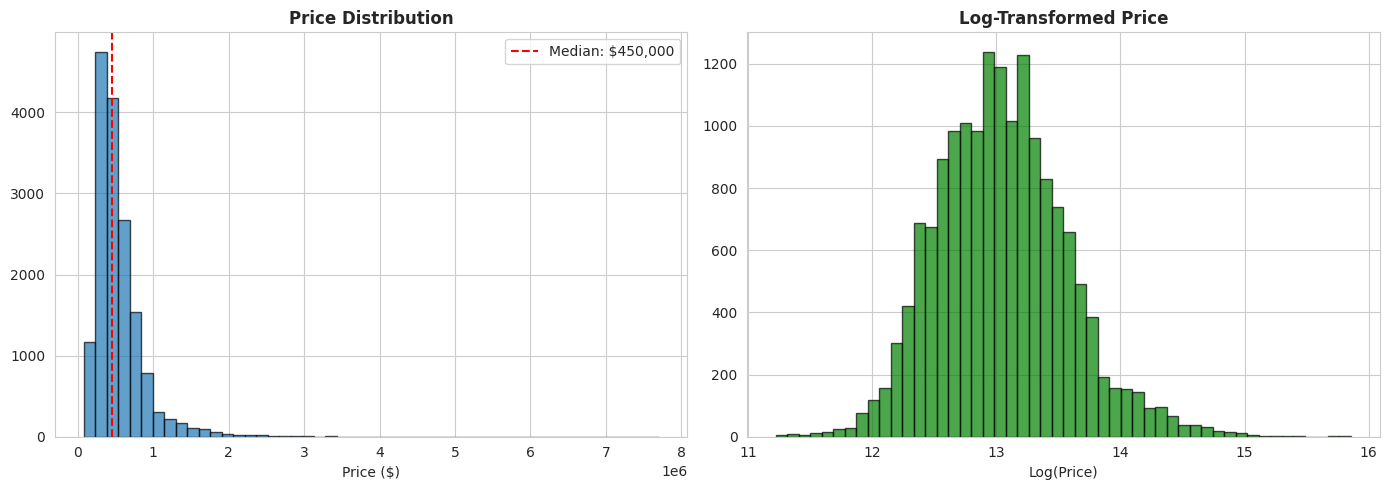

Price range: $75,000 - $7,700,000
Median: $450,000


In [7]:
# Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original price
axes[0].hist(train_df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Price Distribution', fontweight='bold')
axes[0].set_xlabel('Price ($)')
axes[0].axvline(train_df['price'].median(), color='red', linestyle='--', 
                label=f'Median: ${train_df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed price
axes[1].hist(np.log1p(train_df['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Log-Transformed Price', fontweight='bold')
axes[1].set_xlabel('Log(Price)')

plt.tight_layout()
plt.show()

print(f"Price range: ${train_df['price'].min():,.0f} - ${train_df['price'].max():,.0f}")
print(f"Median: ${train_df['price'].median():,.0f}")

In [8]:
# Correlation Analysis
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id', 'date']]

correlations = train_df[numerical_cols].corr()['price'].sort_values(ascending=False)
print("Top 10 features correlated with price:")
print(correlations.head(10))

Top 10 features correlated with price:
price            1.000000
sqft_living      0.700933
grade            0.664266
sqft_above       0.602648
sqft_living15    0.581781
bathrooms        0.525487
is_luxury        0.486746
quality_score    0.484006
total_rooms      0.463855
view             0.390534
Name: price, dtype: float64


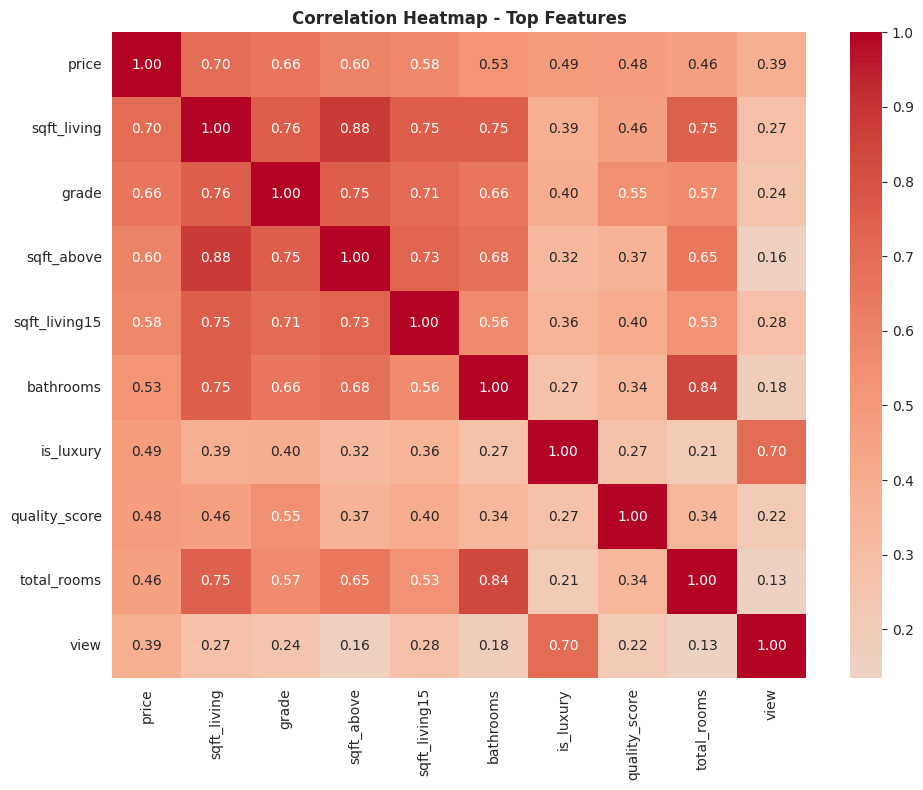

In [9]:
# Correlation Heatmap
top_features = correlations.head(10).index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Top Features', fontweight='bold')
plt.tight_layout()
plt.show()


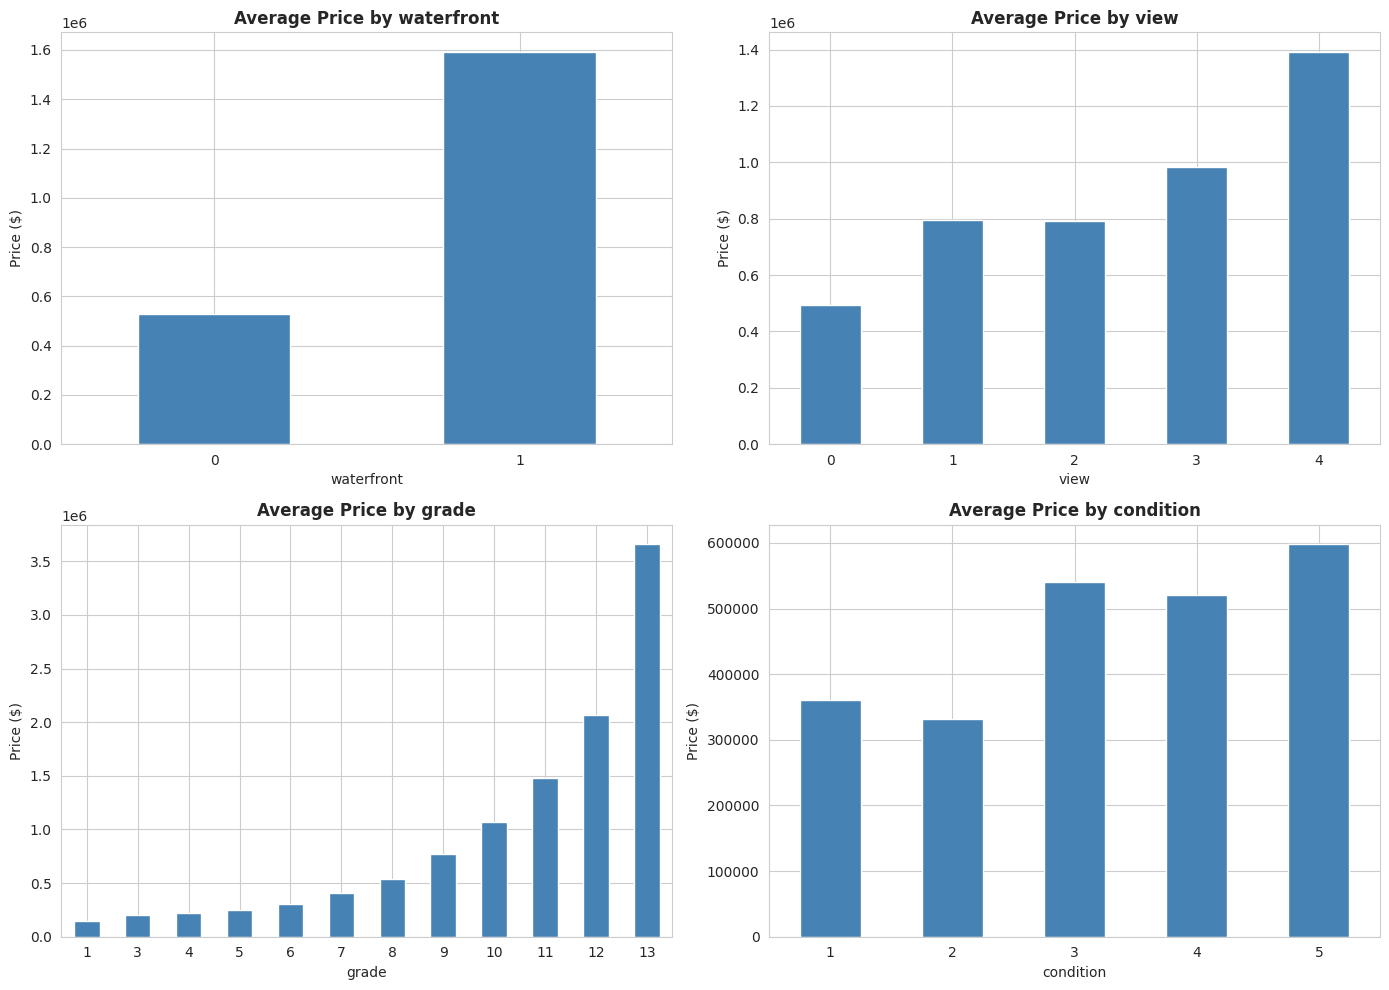

In [10]:
# Price by Key Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

features = ['waterfront', 'view', 'grade', 'condition']
for idx, feat in enumerate(features):
    train_df.groupby(feat)['price'].mean().plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'Average Price by {feat}', fontweight='bold')
    axes[idx].set_ylabel('Price ($)')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

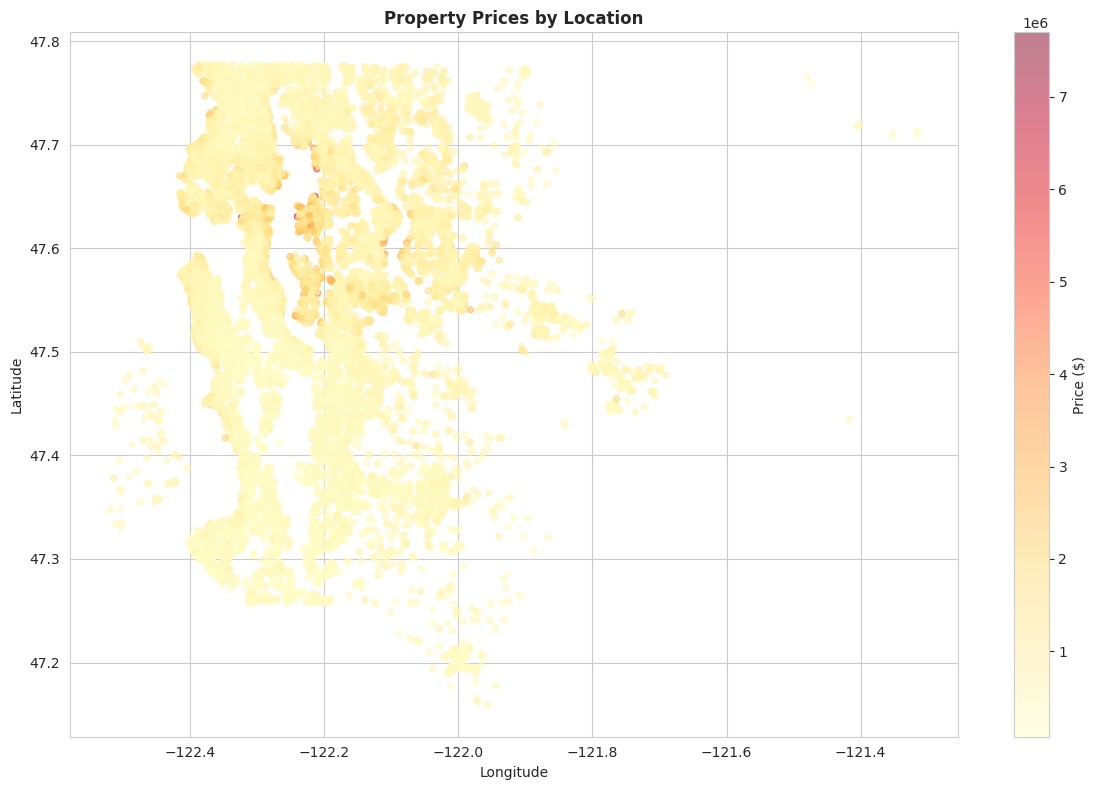


Waterfront premium: 200.3%


In [11]:
# Geographic Price Distribution
plt.figure(figsize=(12, 8))
scatter = plt.scatter(train_df['long'], train_df['lat'], 
                      c=train_df['price'], cmap='YlOrRd', alpha=0.5, s=20)
plt.colorbar(scatter, label='Price ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property Prices by Location', fontweight='bold')
plt.tight_layout()
plt.show()

# Waterfront premium
waterfront_avg = train_df.groupby('waterfront')['price'].mean()
premium = (waterfront_avg[1] / waterfront_avg[0] - 1) * 100
print(f"\nWaterfront premium: {premium:.1f}%")

Found 16110 training images


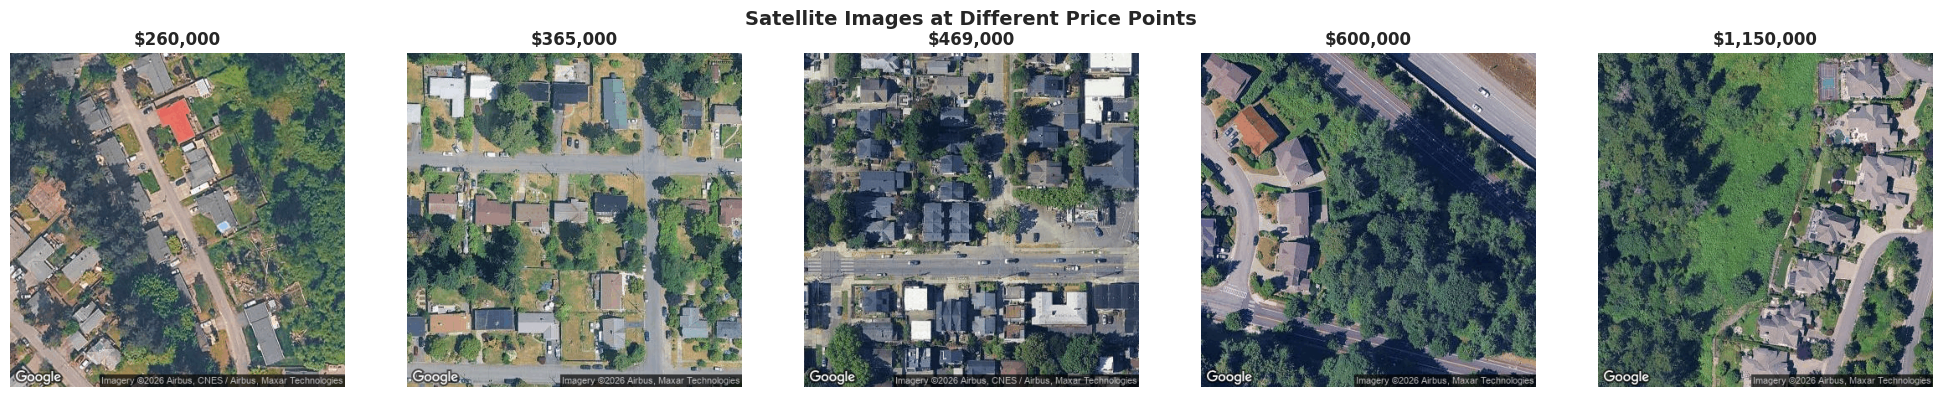

In [12]:
# Display sample satellite images at different price points
images_dir = Path('data/images/train')
images = list(images_dir.glob('*.png'))

if len(images) > 0:
    print(f"Found {len(images)} training images")
    
    # Get samples at different price points
    price_quantiles = train_df['price'].quantile([0.13, 0.34, 0.53, 0.71, 0.95]).values
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for idx, q_price in enumerate(price_quantiles):
        sample_idx = (train_df['price'] - q_price).abs().idxmin()
        prop_id = train_df.loc[sample_idx, 'id']
        price = train_df.loc[sample_idx, 'price']
        
        img_path = images_dir / f"{prop_id}.png"
        if img_path.exists():
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'${price:,.0f}', fontweight='bold')
            axes[idx].axis('off')
    
    plt.suptitle('Satellite Images at Different Price Points', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No images found. Run data_fetcher.py first.")

In [13]:
# Log-transform price for stable training
train_df['price_original'] = train_df['price']
train_df['price'] = np.log1p(train_df['price'])

print("Price normalized with log transform")
print(f"Original: ${train_df['price_original'].min():,.0f} - ${train_df['price_original'].max():,.0f}")
print(f"Log: {train_df['price'].min():.2f} - {train_df['price'].max():.2f}")

# Save processed data
Path('data/processed').mkdir(parents=True, exist_ok=True)
train_df.to_csv('data/processed/train_processed.csv', index=False)
test_df.to_csv('data/processed/test_processed.csv', index=False)

print("\nProcessed data saved!")
print(f"Training: data/processed/train_processed.csv ({len(train_df)} samples)")
print(f"Test: data/processed/test_processed.csv ({len(test_df)} samples)")

Price normalized with log transform
Original: $75,000 - $7,700,000
Log: 11.23 - 15.86

Processed data saved!
Training: data/processed/train_processed.csv (16209 samples)
Test: data/processed/test_processed.csv (5404 samples)


# Model Training

In [14]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
import cv2

warnings.filterwarnings('ignore')

# Ensure GPU is enabled before starting processing.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Load processed data
train_df = pd.read_csv('data/processed/train_processed.csv')
test_df = pd.read_csv('data/processed/test_processed.csv')

print(f"Training: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Price and Price_original is not present in test_df.")
# Feature columns
feature_cols = [col for col in train_df.columns 
               if col not in ['id', 'date', 'price', 'price_original', 'price_per_sqft']]
print(f"\nFeatures: {len(feature_cols)}")

Training: (16209, 35)
Test: (5404, 33)
Price and Price_original is not present in test_df.

Features: 31


In [16]:
# Prepare data
X = train_df[feature_cols]
y = train_df['price']  # Log-transformed

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Train: {len(X_train)}, Val: {len(X_val)}")

Train: 11346, Val: 4863


In [17]:
# Train XGBoost baseline
print("Training XGBoost baseline...")
xgb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_val_pred = xgb_model.predict(X_val_scaled)

# Evaluate
baseline_results = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, xgb_train_pred)),
    'val_rmse': np.sqrt(mean_squared_error(y_val, xgb_val_pred)),
    'val_r2': r2_score(y_val, xgb_val_pred),
    'val_mae': mean_absolute_error(y_val, xgb_val_pred)
}

print(f"\nBaseline (XGBoost) Results:")
print(f"Train RMSE: {baseline_results['train_rmse']:.4f}")
print(f"Val RMSE: {baseline_results['val_rmse']:.4f}")
print(f"Val R²: {baseline_results['val_r2']:.4f}")

Training XGBoost baseline...

Baseline (XGBoost) Results:
Train RMSE: 0.1250
Val RMSE: 0.1666
Val R²: 0.8975


In [18]:
# Dataset class for images
class ImageDataset(Dataset):
    def __init__(self, df, image_dir, target_col='price', is_training=True):
        self.image_dir = Path(image_dir)
        self.target_col = target_col
        
        # Filter valid images
        valid_ids = []
        for idx, row in df.iterrows():
            if (self.image_dir / f"{row['id']}.png").exists():
                valid_ids.append(idx)
        
        self.df = df.loc[valid_ids].reset_index(drop=True)
        print(f"Using {len(self.df)}/{len(df)} samples with images")
        
        # Targets
        if target_col and target_col in self.df.columns:
            self.targets = self.df[target_col].values.astype(np.float32)
        else:
            self.targets = None
        
        # Transforms
        if is_training:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        prop_id = self.df.iloc[idx]['id']
        img = Image.open(self.image_dir / f"{prop_id}.png").convert('RGB')
        img = self.transform(img)
        
        if self.targets is not None:
            return img, torch.tensor(self.targets[idx])
        return img

print("Dataset class defined")

Dataset class defined


In [19]:
# ResNet18 Model for regression
class ResNet18Regressor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        for param in list(self.features.parameters())[:-10]:
            param.requires_grad = True
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x
    
    def get_features(self, x):
        """Extract features before regression head"""
        with torch.no_grad():
            x = self.features(x)
            x = x.view(x.size(0), -1)
        return x

print("✓ ResNet18 model defined")

✓ ResNet18 model defined


In [20]:
# Create datasets and dataloaders
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print("Creating datasets...")
train_dataset = ImageDataset(train_data, 'data/images/train', is_training=True)
val_dataset = ImageDataset(val_data, 'data/images/train', is_training=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Creating datasets...
Using 12967/12967 samples with images
Using 3242/3242 samples with images
Train batches: 406, Val batches: 102


In [21]:
# Train CNN
cnn_model = ResNet18Regressor().to(device)

# Differential learning rates: lower for pretrained backbone, higher for new head
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.MSELoss()

print(f"Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

# Training loop
num_epochs = 15
best_val_loss = float('inf')
cnn_history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    # Train
    cnn_model.train()
    train_loss = 0
    for images, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        targets = targets.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validate
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = cnn_model(images)
            val_loss += criterion(outputs, targets).item()
    
    val_loss /= len(val_loader)
    
    cnn_history['train_loss'].append(train_loss)
    cnn_history['val_loss'].append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cnn_model.state_dict(), 'models/cnn_model.pth')
    
    print(f"Train: {train_loss:.4f}, Val: {val_loss:.4f}")

print(f"\nCNN training complete! Best Val Loss: {best_val_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


Parameters: 11,308,097


Epoch 1/15: 100%|██████████| 406/406 [00:50<00:00,  7.99it/s]


Train: 13.4929, Val: 0.2404


Epoch 2/15: 100%|██████████| 406/406 [00:48<00:00,  8.38it/s]


Train: 1.8914, Val: 0.1690


Epoch 3/15: 100%|██████████| 406/406 [00:48<00:00,  8.36it/s]


Train: 1.8542, Val: 0.2053


Epoch 4/15: 100%|██████████| 406/406 [00:48<00:00,  8.45it/s]


Train: 1.8589, Val: 0.1949


Epoch 5/15: 100%|██████████| 406/406 [00:47<00:00,  8.48it/s]


Train: 1.8379, Val: 0.1801


Epoch 6/15: 100%|██████████| 406/406 [00:47<00:00,  8.48it/s]


Train: 1.7940, Val: 0.1914


Epoch 7/15: 100%|██████████| 406/406 [00:47<00:00,  8.55it/s]


Train: 1.8204, Val: 0.2600


Epoch 8/15: 100%|██████████| 406/406 [00:47<00:00,  8.55it/s]


Train: 1.7305, Val: 0.1654


Epoch 9/15: 100%|██████████| 406/406 [00:47<00:00,  8.57it/s]


Train: 1.7505, Val: 0.1445


Epoch 10/15: 100%|██████████| 406/406 [00:47<00:00,  8.54it/s]


Train: 1.7480, Val: 0.1260


Epoch 11/15: 100%|██████████| 406/406 [00:47<00:00,  8.54it/s]


Train: 1.7906, Val: 0.1957


Epoch 12/15: 100%|██████████| 406/406 [00:48<00:00,  8.42it/s]


Train: 1.7351, Val: 0.1285


Epoch 13/15: 100%|██████████| 406/406 [00:47<00:00,  8.59it/s]


Train: 1.7263, Val: 0.1463


Epoch 14/15: 100%|██████████| 406/406 [00:48<00:00,  8.45it/s]


Train: 1.7109, Val: 0.1328


Epoch 15/15: 100%|██████████| 406/406 [00:47<00:00,  8.54it/s]


Train: 1.7536, Val: 0.1240

CNN training complete! Best Val Loss: 0.1240


In [22]:
print("Generating predictions for fusion...")

# Load best CNN model
cnn_model.load_state_dict(torch.load('models/cnn_model.pth'))
cnn_model.eval()

# Get CNN predictions for validation set
cnn_val_preds = []
cnn_val_targets = []
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc='CNN predictions'):
        images = images.to(device)
        outputs = cnn_model(images)
        cnn_val_preds.extend(outputs.cpu().numpy().flatten())
        cnn_val_targets.extend(targets.numpy())

cnn_val_preds = np.array(cnn_val_preds)
cnn_val_targets = np.array(cnn_val_targets)

# Get XGBoost predictions for same validation samples
# Match validation samples by ID
val_ids = set(val_dataset.df['id'].values)
val_mask = train_df['id'].isin(val_ids)
xgb_val_subset = xgb_model.predict(scaler.transform(train_df[val_mask][feature_cols]))

print(f"CNN predictions: {len(cnn_val_preds)}")
print(f"XGBoost predictions: {len(xgb_val_subset)}")

Generating predictions for fusion...


CNN predictions: 100%|██████████| 102/102 [00:08<00:00, 11.72it/s]


CNN predictions: 3242
XGBoost predictions: 3275


In [23]:
# Train meta-learner (Ridge regression on stacked predictions)
print("Training meta-learner...")

val_df_ordered = val_dataset.df.copy()
val_df_ordered['cnn_pred'] = cnn_val_preds

# Get XGBoost predictions
xgb_preds_ordered = xgb_model.predict(scaler.transform(val_df_ordered[feature_cols]))
val_df_ordered['xgb_pred'] = xgb_preds_ordered

# Stack predictions
stacked_features = np.column_stack([val_df_ordered['xgb_pred'], val_df_ordered['cnn_pred']])
stacked_targets = val_df_ordered['price'].values

# Split for meta-learner training
X_stack_train, X_stack_val, y_stack_train, y_stack_val = train_test_split(
    stacked_features, stacked_targets, test_size=0.3, random_state=42
)

# Train meta-learner
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(X_stack_train, y_stack_train)

# Evaluate
meta_preds = meta_learner.predict(X_stack_val)

fusion_results = {
    'val_rmse': np.sqrt(mean_squared_error(y_stack_val, meta_preds)),
    'val_r2': r2_score(y_stack_val, meta_preds),
    'val_mae': mean_absolute_error(y_stack_val, meta_preds)
}

print(f"\n✓ Fusion (Stacking) Results:")
print(f"  Val RMSE: {fusion_results['val_rmse']:.4f}")
print(f"  Val R²: {fusion_results['val_r2']:.4f}")
print(f"  Val MAE: {fusion_results['val_mae']:.4f}")

Training meta-learner...

✓ Fusion (Stacking) Results:
  Val RMSE: 0.1593
  Val R²: 0.9101
  Val MAE: 0.1170


MODEL COMPARISON
            Model  Val RMSE   Val R²
XGBoost (Tabular)  0.166597 0.897453
 ResNet18 (Image)  0.351433 0.552443
Stacking (Fusion)  0.159322 0.910114


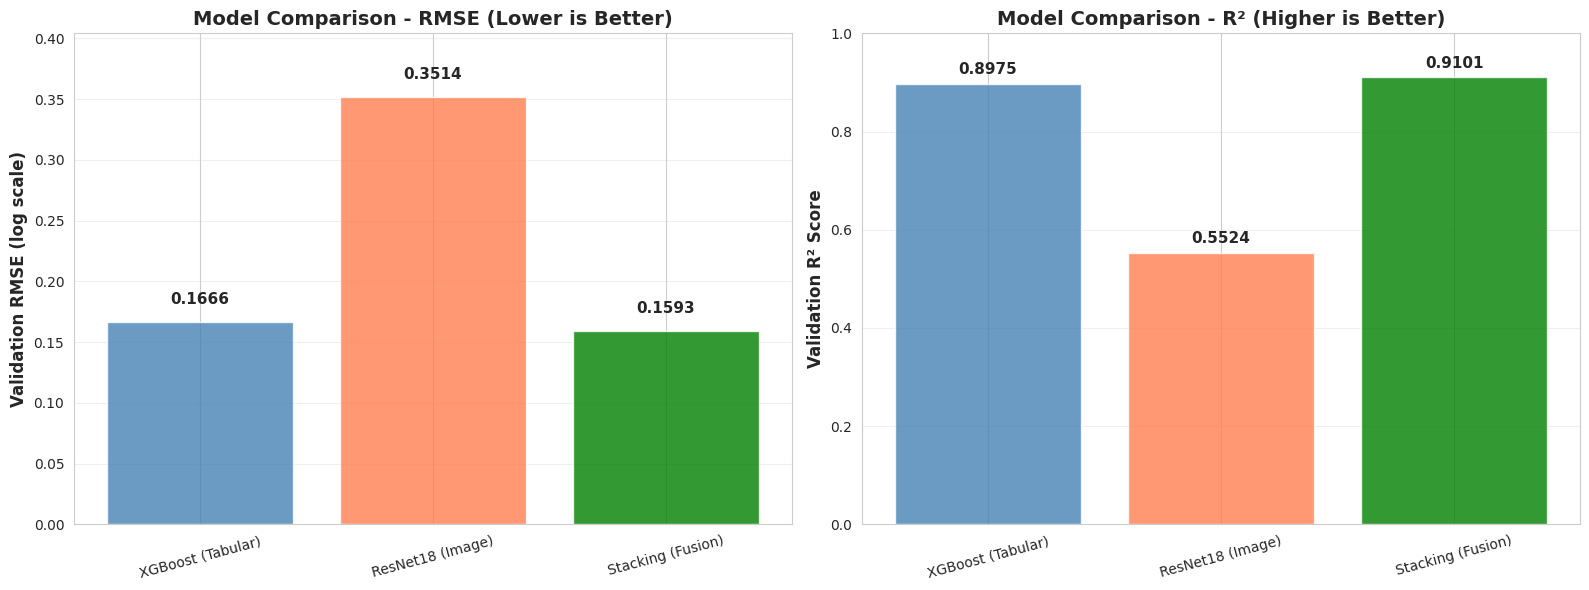


Analysis:
XGBoost captures interior features (sqft, bedrooms, grade) - strongest predictors
CNN captures visual context (lot size, neighborhood, waterfront proximity)
Fusion combines both → slight improvement over tabular-only
Improvement from fusion: 4.4% RMSE reduction
This is expected: satellite images can't see interior features that dominate price


In [3]:
# Compare all models
# Calculate CNN R² from predictions
cnn_r2 = r2_score(cnn_val_targets, cnn_val_preds)
cnn_rmse = np.sqrt(mean_squared_error(cnn_val_targets, cnn_val_preds))

comparison = pd.DataFrame({
    'Model': ['XGBoost (Tabular)', 'ResNet18 (Image)', 'Stacking (Fusion)'],
    'Val RMSE': [baseline_results['val_rmse'], cnn_rmse, fusion_results['val_rmse']],
    'Val R²': [baseline_results['val_r2'], cnn_r2, fusion_results['val_r2']]
})

print("MODEL COMPARISON")
print(comparison.to_string(index=False))

# Visualize with dual bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

models = comparison['Model']
rmse_vals = comparison['Val RMSE']
r2_vals = comparison['Val R²']
colors = ['steelblue', 'coral', 'green']

# RMSE Chart
bars1 = ax1.bar(models, rmse_vals, color=colors, alpha=0.8)
ax1.set_ylabel('Validation RMSE (log scale)', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison - RMSE (Lower is Better)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(rmse_vals) * 1.15)

for bar, val in zip(bars1, rmse_vals):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.015, 
            f'{val:.4f}', ha='center', fontweight='bold', fontsize=11)

# R² Chart
bars2 = ax2.bar(models, r2_vals, color=colors, alpha=0.8)
ax2.set_ylabel('Validation R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison - R² (Higher is Better)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)

for bar, val in zip(bars2, r2_vals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
            f'{val:.4f}', ha='center', fontweight='bold', fontsize=11)

# Rotate x-axis labels for better readability
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis
print("\nAnalysis:")
print("XGBoost captures interior features (sqft, bedrooms, grade) - strongest predictors")
print("CNN captures visual context (lot size, neighborhood, waterfront proximity)")
print("Fusion combines both → slight improvement over tabular-only")
print(f"Improvement from fusion: {(baseline_results['val_rmse'] - fusion_results['val_rmse']) / baseline_results['val_rmse'] * 100:.1f}% RMSE reduction")
print("This is expected: satellite images can't see interior features that dominate price")

Generating Grad-CAM visualizations...


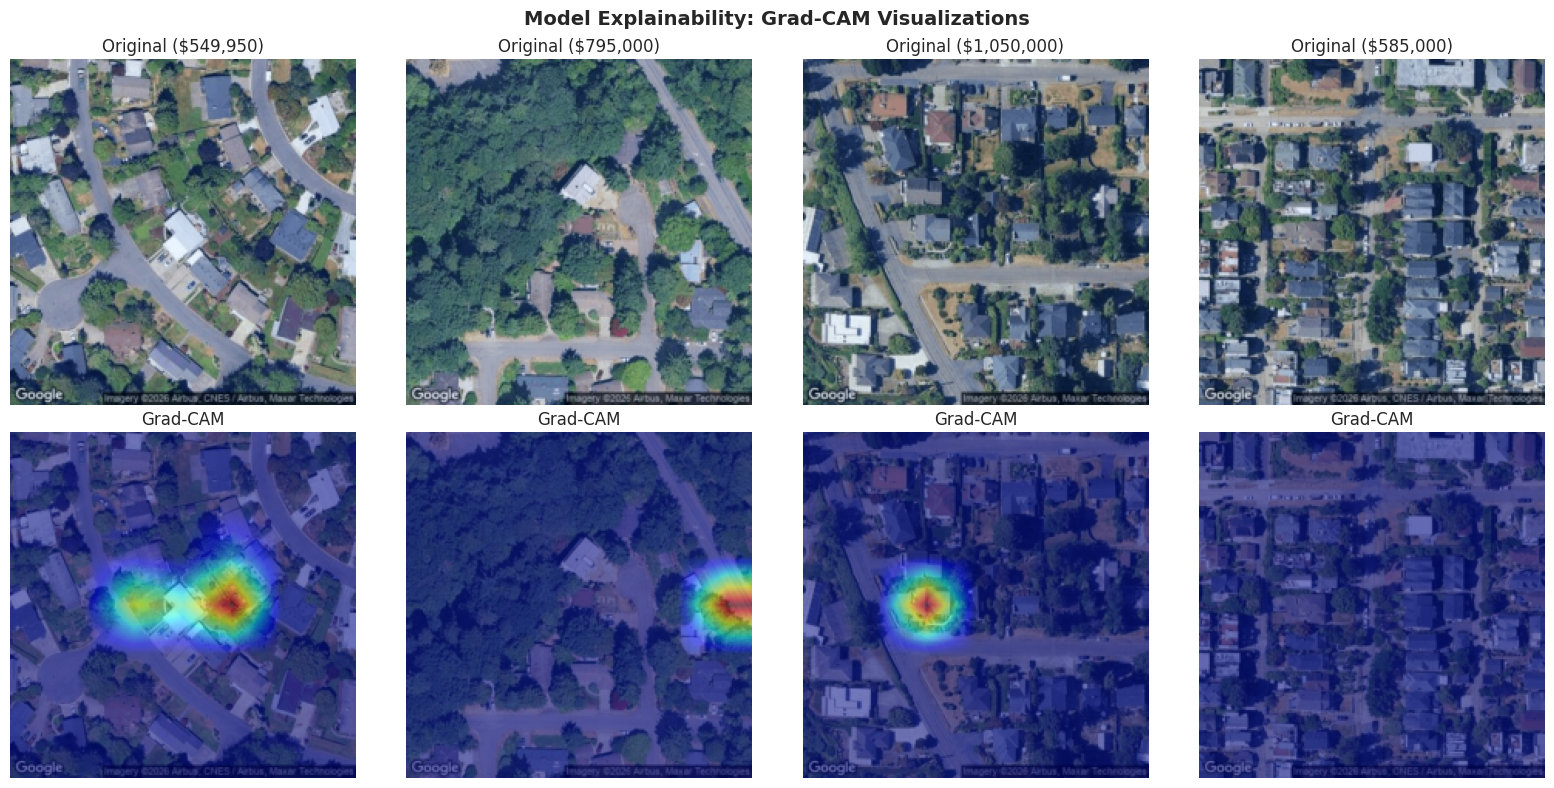

In [25]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image):
        self.model.eval()
        output = self.model(input_image)
        
        self.model.zero_grad()
        output.backward()
        
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.squeeze().cpu().numpy()

# Generate Grad-CAM for sample images
print("Generating Grad-CAM visualizations...")

# Get target layer (last conv layer of ResNet18)
# ResNet18: features[7] = layer4 (last block), [-1].conv2 = last conv
target_layer = cnn_model.features[7][-1].conv2
gradcam = GradCAM(cnn_model, target_layer)

# Visualize on sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
sample_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

for idx, (img, target) in enumerate(sample_loader):
    if idx >= 4:
        break
    
    img = img.to(device)
    img.requires_grad = True
    
    cam = gradcam.generate_cam(img)
    
    # Original image
    orig_img = img.detach().squeeze().cpu().permute(1, 2, 0).numpy()
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    
    # Resize CAM
    cam_resized = cv2.resize(cam, (224, 224))
    
    # Plot
    axes[0, idx].imshow(orig_img)
    axes[0, idx].set_title(f'Original (${np.expm1(target.item()):,.0f})')
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(orig_img)
    axes[1, idx].imshow(cam_resized, cmap='jet', alpha=0.5)
    axes[1, idx].set_title('Grad-CAM')
    axes[1, idx].axis('off')

plt.suptitle('Model Explainability: Grad-CAM Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('models/gradcam_samples.png', dpi=300)
plt.show()

In [26]:
# Generate predictions on test set
print("Generating test predictions...")

# Create test dataset
test_dataset = ImageDataset(test_df, 'data/images/test', target_col=None, is_training=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get CNN predictions
cnn_test_preds = []
cnn_model.eval()
with torch.no_grad():
    for images in tqdm(test_loader, desc='CNN predictions'):
        images = images.to(device)
        outputs = cnn_model(images)
        cnn_test_preds.extend(outputs.cpu().numpy().flatten())

# Get XGBoost predictions 
xgb_test_preds = xgb_model.predict(scaler.transform(test_dataset.df[feature_cols]))

# Combine with meta-learner
stacked_test = np.column_stack([xgb_test_preds, cnn_test_preds])
final_preds_log = meta_learner.predict(stacked_test)

# Convert to original scale
final_preds = np.expm1(final_preds_log)

print(f"\nPredictions generated!")
print(f"Mean: ${final_preds.mean():,.0f}")
print(f"Range: ${final_preds.min():,.0f} - ${final_preds.max():,.0f}")

Generating test predictions...
Using 5404/5404 samples with images


CNN predictions: 100%|██████████| 169/169 [00:14<00:00, 11.71it/s]


Predictions generated!
Mean: $539,785
Range: $136,962 - $5,787,766


In [27]:
# Create submission file
submission = pd.DataFrame({
    'id': test_dataset.df['id'].values,
    'predicted_price': final_preds
})

submission.to_csv(f'23323023_final.csv', index=False)

print(f"Submission saved: 23323023_final.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Save models
pickle.dump(xgb_model, open('models/xgb_model.pkl', 'wb'))
pickle.dump(scaler, open('models/scaler.pkl', 'wb'))
pickle.dump(meta_learner, open('models/meta_learner.pkl', 'wb'))
print("\nAll models saved!")

Submission saved: 23323023_final.csv

First 10 predictions:
           id  predicted_price
0  2591820310     3.723950e+05
1  7974200820     8.309932e+05
2  7701450110     1.115924e+06
3  9522300010     1.799985e+06
4  9510861140     6.898605e+05
5  1761300310     2.424914e+05
6  7732410120     7.951734e+05
7  7010701383     6.403918e+05
8   291310170     4.681076e+05
9  4232901990     5.882072e+05

All models saved!
